In [ ]:
# Load the dataset
import pandas as pd

df = pd.read_csv("data.csv")  # Replace with the actual dataset path
df = df.sample(n=5000, random_state=42).reset_index(drop=True)

# Display the first few rows to understand the structure
df.head()


,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.910,1977,0.500,['Idris Muhammad'],0.894,273067,0.5210,0,0KdzyvsBqX1HV3uLxGm2JV,0.772,4,0.068,-7.048,1,Camby Bolongo,34,1977,0.0847,126.805
1,0.583,1976,0.930,['Stan Getz'],0.585,182200,0.2720,0,1f4eO5waC6glPLXUhYKLm2,0.115,11,0.128,-16.693,0,Just One of Those Things,26,1976,0.0802,90.104
2,0.647,1994,0.157,"['Warren G', 'The Twinz']",0.878,179933,0.5200,1,1X07ZfF5KQt8dyJ5kAkVAQ,0.000,7,0.173,-12.609,1,Recognize,38,1994-06-07,0.4030,90.744
3,0.196,1957,0.937,['Red Garland Quintet'],0.463,925947,0.2870,0,5wmMDeM4qvLfwqLa2cvoks,0.837,0,0.112,-11.758,0,Soul Junction,13,1957,0.0363,186.764
4,0.422,1921,0.995,['Ignacio Corsini'],0.648,154240,0.0995,0,0SK1upzAP6NvIgF0uGh6z2,0.846,11,0.112,-22.429,1,Flor Marchita - Remasterizado,0,1921-03-20,0.1050,71.978


In [ ]:
# Check for missing values
df.isnull().sum()




,0
valence,0
year,0
acousticness,0
artists,0
danceability,0
duration_ms,0
energy,0
explicit,0
id,0
instrumentalness,0


In [ ]:
from sklearn.preprocessing import StandardScaler

# List of relevant numerical features
numerical_features = [
    "valence", "danceability", "energy", "tempo",
    "acousticness", "liveness", "speechiness", "instrumentalness"
]

# Standardize the numerical features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[numerical_features]), columns=numerical_features)

df_scaled.head()


,valence,danceability,energy,tempo,acousticness,liveness,speechiness,instrumentalness
0,1.473178,2.032267,0.142150,0.310507,-0.005840,-0.783298,-0.107375,1.916073
1,0.226049,0.276101,-0.771789,-0.886487,1.126217,-0.446557,-0.133457,-0.171477
2,0.470135,1.941333,0.138480,-0.865614,-0.908852,-0.194001,1.737477,-0.536877
3,-1.249911,-0.417272,-0.716732,2.266056,1.144646,-0.536354,-0.387900,2.122604
4,-0.387981,0.634154,-1.404939,-1.477663,1.297342,-0.536354,0.010283,2.151200


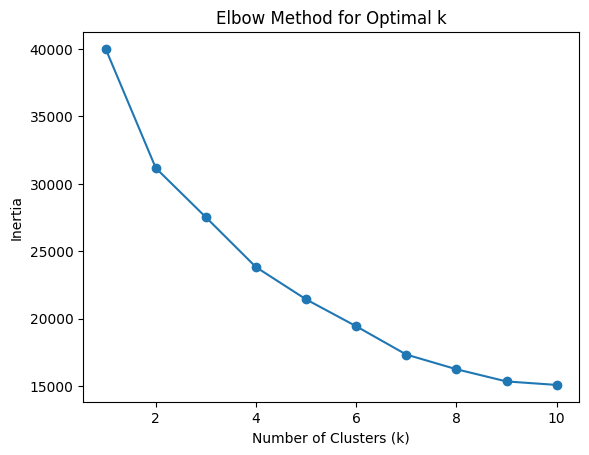

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Determine the optimal number of clusters using the Elbow Method
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


In [ ]:
# Apply K-Means clustering with optimal k (let's assume k=5)
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df["Cluster"] = kmeans.fit_predict(df_scaled)

# Display the cluster assignment
df[['name', 'Cluster']].head()


,name,Cluster
0,Camby Bolongo,1
1,Just One of Those Things,0
2,Recognize,1
3,Soul Junction,2
4,Flor Marchita - Remasterizado,2


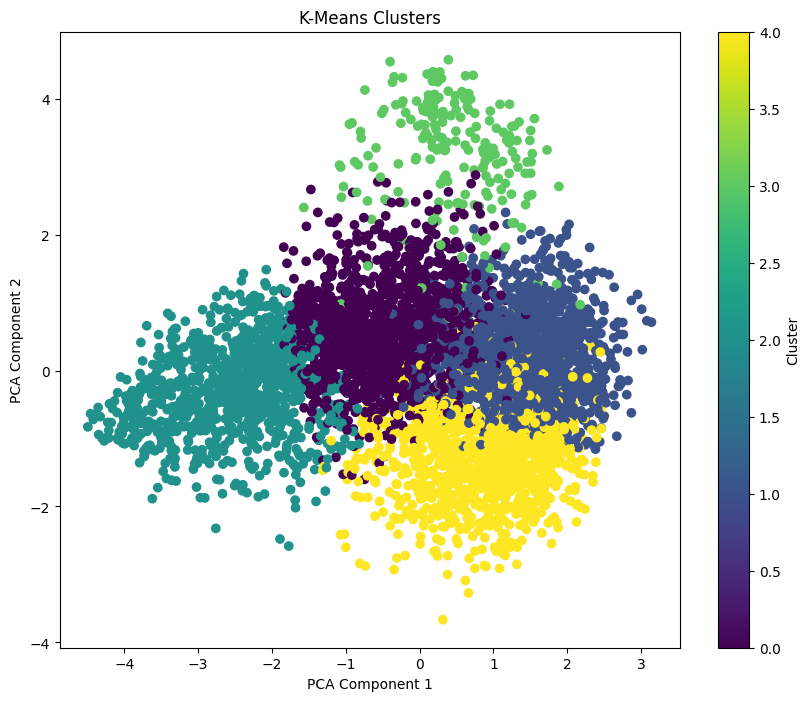

In [ ]:
from sklearn.decomposition import PCA

# Perform PCA for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

# Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df['Cluster'], cmap='viridis')
plt.title('K-Means Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_songs(song_name, df, num_recommendations=5):
    # Get the cluster of the input song
    song_cluster = df[df['name'] == song_name]['Cluster'].values[0]

    # Filter songs from the same cluster
    same_cluster_songs = df[df['Cluster'] == song_cluster]

    # Calculate similarity within the cluster
    song_index = same_cluster_songs[same_cluster_songs['name'] == song_name].index[0]
    cluster_features = same_cluster_songs[numerical_features]
    similarity = cosine_similarity(cluster_features, cluster_features)

    # Get top recommendations (excluding the input song)
    similar_songs = np.argsort(similarity[song_index])[-(num_recommendations + 1):-1][::-1]
    recommendations = same_cluster_songs.iloc[similar_songs][['name', 'year', 'artists']]

    return recommendations




In [ ]:
# Example usage
input_song = "Camby Bolongo"
recommended_songs = recommend_songs(input_song, df, num_recommendations=5)
print(f"Songs similar to '{input_song}':")
print(recommended_songs)

Songs similar to 'Camby Bolongo':
                                          name  year                 artists
3444                         Bitch to the Boys  1982            ['Shakatak']
3027  Chella llà - Instrument and base Version  1942  ['Orchestra Studio 7']
4899                            Danse Fambeaux  1968            ['Dr. John']
3124      Aragon - From The "Coffy" Soundtrack  1973           ['Roy Ayers']
647                                 Into Black  2011              ['Blouse']


In [ ]:
df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,Cluster
0,0.910,1977,0.500,['Idris Muhammad'],0.894,273067,0.5210,0,0KdzyvsBqX1HV3uLxGm2JV,0.772,4,0.068,-7.048,1,Camby Bolongo,34,1977,0.0847,126.805,1
1,0.583,1976,0.930,['Stan Getz'],0.585,182200,0.2720,0,1f4eO5waC6glPLXUhYKLm2,0.115,11,0.128,-16.693,0,Just One of Those Things,26,1976,0.0802,90.104,0
2,0.647,1994,0.157,"['Warren G', 'The Twinz']",0.878,179933,0.5200,1,1X07ZfF5KQt8dyJ5kAkVAQ,0.000,7,0.173,-12.609,1,Recognize,38,1994-06-07,0.4030,90.744,1
3,0.196,1957,0.937,['Red Garland Quintet'],0.463,925947,0.2870,0,5wmMDeM4qvLfwqLa2cvoks,0.837,0,0.112,-11.758,0,Soul Junction,13,1957,0.0363,186.764,2
4,0.422,1921,0.995,['Ignacio Corsini'],0.648,154240,0.0995,0,0SK1upzAP6NvIgF0uGh6z2,0.846,11,0.112,-22.429,1,Flor Marchita - Remasterizado,0,1921-03-20,0.1050,71.978,2


In [ ]:
# Example usage
input_song = "Soul Junction"
recommended_songs = recommend_songs(input_song, df, num_recommendations=5)
print(f"Songs similar to '{input_song}':")
print(recommended_songs)

Songs similar to 'Soul Junction':
                                                   name  year  \
1088                                Legends of the Fall  1995   
3489  Water Music Suite No. 1 In F, HWV 348: 2. Adag...  1983   
2473  Le sacre du printemps: Part 1 "Adoration of th...  1948   
1277                                    Saving Buckbeak  2004   
3385                Tristan und Isolde, WWV 90: Prelude  1953   

                                                artists  
1088                    ['James Horner', 'Vic Frasier']  
3489  ['George Frideric Handel', 'The English Concer...  
2473  ['Igor Stravinsky', 'Columbia Symphony Orchest...  
1277                                  ['John Williams']  
3385             ['Richard Wagner', 'Arturo Toscanini']  
